In [1]:
import xarray
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from utils.plotting import prediction_error_plot


In [ ]:
stations = xarray.open_zarr('/scratch/snx3000/kschuurm/ZARR/IEA_PVPS_europe.zarr')
sarah = xarray.open_zarr('/scratch/snx3000/kschuurm/ZARR/SARAH3.zarr')

In [ ]:
print(stations.station_name.values)

In [ ]:
proj = ccrs.PlateCarree()

fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=proj))

gl = axis.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

axis.coastlines()

lat = stations.latitude.values
lon = stations.longitude.values
name = stations.station_name.values
axis.scatter(x=lon, y=lat, c='r')
for i, txt in enumerate(name):
    axis.annotate(txt, (lon[i], lat[i]))

sarah.SIS.isel(time = 10310).plot.imshow(ax=axis, transform = proj)

In [7]:
lat = stations.sel(station_name='CAB').latitude.data
lon = stations.sel(station_name='CAB').longitude.values
ilat = (np.abs(sarah.lat - lat)).argmin().values
ilon = (np.abs(sarah.lon - lon)).argmin().values



In [66]:
time_window = 30
rolling = stations.sel(station_name='CAB') \
        .rolling(time=time_window,center=False) \
        .mean().dropna(dim='time')
# rolling average of X minutes (seviri takes X min to create an image, RSS=5min, normal full disk 12min)
# mean becomes a nan if a single nan value is encountered in GHI

# mean index is the right most index -> convert to left most index to relate to hrseviri
rolling['time'] = rolling['time'] - np.timedelta64(time_window, 'm')

print('sarah samples',len(sarah.time))
print('station samples', len(rolling.time))
timenotnan = set(rolling.time.values).intersection(set(sarah.time.values))
timenotnan = np.sort(np.array(list(timenotnan)))
print('collocated samples:', len(timenotnan))

sarah samples 139915
station samples 782424
collocated samples: 25907


In [67]:
sarah_timeseries = sarah.sel(time=timenotnan).isel(lat=ilat, lon=ilon)
CAB_timeseries = rolling.sel(time=timenotnan)
combined = xarray.merge([sarah_timeseries, CAB_timeseries])
combined

<xarray.Dataset>
Dimensions:       (time: 25907)
Coordinates:
    lat           float32 51.97
    lon           float32 4.925
  * time          (time) datetime64[ns] 2015-01-01T09:00:00 ... 2019-09-30T16...
    elevation     float32 dask.array<chunksize=(), meta=np.ndarray>
    latitude      float32 dask.array<chunksize=(), meta=np.ndarray>
    longitude     float32 dask.array<chunksize=(), meta=np.ndarray>
    station_name  <U3 'CAB'
Data variables:
    SID           (time) float32 dask.array<chunksize=(9,), meta=np.ndarray>
    SIS           (time) float32 dask.array<chunksize=(9,), meta=np.ndarray>
    Azim          (time) float32 dask.array<chunksize=(25907,), meta=np.ndarray>
    DIF           (time) float32 dask.array<chunksize=(25907,), meta=np.ndarray>
    DNI           (time) float32 dask.array<chunksize=(25907,), meta=np.ndarray>
    Elev          (time) float32 dask.array<chunksize=(25907,), meta=np.ndarray>
    GHI           (time) float32 dask.array<chunksize=(25907,), meta=np.ndarray>
    GHIcalc       (time) float32 dask.array<chunksize=(25907,), meta=np.ndarray>
    Kc            (time) float32 dask.array<chunksize=(25907,), meta=np.ndarray>

In [68]:
error = CAB_timeseries.GHI - sarah_timeseries.SIS

In [69]:
error = error.compute().load()

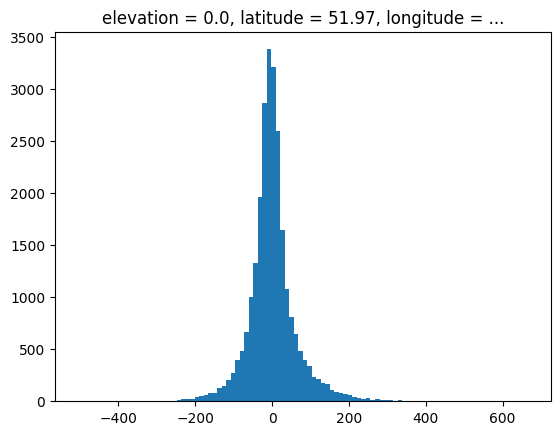

In [70]:
a = error.plot.hist(bins=100)

In [65]:
print('Mean:', error.mean().values, 'Median:', error.median().values, 'Std:', error.std().values)

Mean: -0.62670904 Median: -5.424988 Std: 70.58374


In [52]:
dif = combined['GHIcalc'] - combined['DNI']
dif.compute().load()

<xarray.DataArray (time: 29462)>
array([ 52.822918,  68.447914,  59.9375  , ..., 107.46355 ,  61.604168,
        30.968752], dtype=float32)
Coordinates:
    lat           float32 51.97
    lon           float32 4.925
  * time          (time) datetime64[ns] 2015-01-01T09:00:00 ... 2019-09-30T16...
    elevation     float32 0.0
    latitude      float32 51.97
    longitude     float32 4.927
    station_name  <U3 'CAB'

In [53]:
a = dif - combined['DIF'].values

In [54]:
a.mean().values

array(-142.50291, dtype=float32)